# Approach based on density maps generation

In [1]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as data
#from torchvision import datasets
#from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
# Torchvision library
import torchvision
import torch.nn as nn
from tqdm import tqdm # plot progress bars
import numpy as np

import os
import pandas as pd
#from torchvision.io import read_image
from PIL import Image
import seaborn as sns
import copy
import cv2
import random
import time

from torch.utils.tensorboard import SummaryWriter

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)


## Data adquisition  definition of the Dataset class and Dataloader

In [3]:
class CustomImageDataset(Dataset):
    """As builsing back the images to the original size is usefull for counting the number of kernels
       I need to pass this information """
    def __init__(self, annotations_file, img_dir,scale, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir    = img_dir
        self.transform  = transform
        self.target_transform = target_transform
        self.scale = scale

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path) # I load it as a PIL image so I can perform some transforms that are not available for tensors.
        label_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 2])
        label    = cv2.imread(label_path,flags=cv2.IMREAD_ANYDEPTH)
        label *= self.scale
        shape = label.shape
        count = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
                    
        return image, label, shape, count
    

In [4]:
### Define transforms
train_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize((224,224)),
                                      ])

# The test dataset must remain as original as possible
test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224,224)),
                                     ])

target_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224,224)),]) 

In [5]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"

dataset = "corn"

train_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_train_labels.csv" 
train_data_path = path + f"{dataset}_coco/train_set" 

test_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_test_labels.csv" 
test_data_path = path + f"{dataset}_coco/test_set"


In [15]:
### Define dataset
scale = 1e4
train_dataset = CustomImageDataset(train_csv_path, train_data_path,
                                   scale = scale,
                                   transform=train_transforms,
                                   target_transform = target_transform)

test_dataset = CustomImageDataset(test_csv_path, test_data_path,
                                  scale = scale,
                                  transform = test_transforms,
                                  target_transform = target_transform)

In [7]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.80)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")

Number of training examples: 193


In [8]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 193
Number validation examples: 49
Number test examples: 62


In [9]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set
validation_dataset.dataset.transform = test_transforms

In [10]:
# data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


Lets check if dataloaders are working properly

In [11]:
train_features, train_labels, shape,count = next(iter(test_dataloader))

In [12]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

UP = nn.Upsample(size=(shape[0][0],shape[1][0]),mode='bilinear')
img = train_features[0]#.numpy().transpose(1, 2, 0)
img = img[None, :]
img = UP(img)
img = img[0].numpy().transpose(1, 2, 0)

label = train_labels[0]#.numpy().transpose(1, 2, 0)
label = label[None, :]
label = UP(label)
label = label[0].numpy().transpose(1, 2, 0)

print(f"Feature batch shape: {img.shape}")
print(f"Labels batch shape: {label.shape}")

Feature batch shape: torch.Size([62, 3, 224, 224])
Labels batch shape: torch.Size([62, 1, 224, 224])
Feature batch shape: (1279, 1920, 3)
Labels batch shape: (1279, 1920, 1)


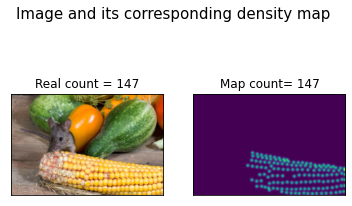

In [13]:
# Display image and label.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Image and its corresponding density map",fontsize=15)
ax1.imshow(img)
ax1.set_title(f"Real count = {count[0]}",fontsize=12)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(label)
ax2.set_title(f"Map count= {int(label.sum()/1e4)}", fontsize=12)
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

# Network architecture

In [16]:
class Map_CNN(nn.Module):
    def __init__(self, Pre_Trained_Encoder):
        super().__init__()
        
        self.encoder     = Pre_Trained_Encoder
         ### Encoder
        self.decoder = nn.Sequential(  
                       nn.Conv2d(in_channels  = 512,      # C1
                                  out_channels = 256,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),                    
                        nn.Conv2d(in_channels  = 256,     # C2    
                                  out_channels = 128,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True), 
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 128,     #C3  
                                  out_channels = 64,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 64,      #C4  
                                  out_channels = 1,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 1,       #C5
                                  out_channels = 1,
                                  kernel_size  = 1,
                                  padding = 0,
                                  stride = 1)
            )
        
    def forward(self, x,mode):
        if (mode == "Train"):
            self.encoder.train()
            self.decoder.train()
        elif (mode == "Test"):
            self.encoder.eval()
            self.decoder.eval()
        y = self.encoder(x)
        y = self.decoder(y)
        return y
    
    
    def train_epoch(self,device,dataloader, loss_fn, optimizer):
        """
        This function train the network for one epoch
        """
        # Train
        loss_list = []
        for x, y,_,_ in dataloader:
            # Move data to device
            x = x.to(device)
            y = y.to(device)
            # Forward
            y_pred = self.forward(x,"Train")
            # Compute loss
            loss = loss_fn(y_pred, y)
            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            #Updata weights
            optimizer.step()
            # Save batch loss
            loss_list.append(loss.detach().cpu().numpy())
        return np.mean(loss_list)

    def validate_epoch(self,device, dataloader, loss_fn):
        """
        This function validate/test the network performance for one epoch of training
        """
        loss_list = []
        # Discable gradient tracking
        with torch.no_grad():
            for x, y,_,_ in dataloader:
                x = x.to(device)
                y = y.to(device)
                y_pred = self.forward(x,"Test")
                loss = loss_fn(y_pred, y)
                loss_list.append(loss.detach().cpu().numpy()) 
        return np.mean(loss_list)
       
    def training_cycle(self, device, training_iterator, test_iterator, loss_fn, optim, num_epochs,
                       verbose= True):
        """
        This function train the network for a desired number of epochs it also test the network 
        reconstruction performance and make plots comparing the input image and the reconstructed one every 5 epochs.
        """
        #initialize the tensorboard writer
        #writer = SummaryWriter()
        #I keep track of losses for plots
        train_loss = []
        val_loss  = []
        for epoch in tqdm(range(num_epochs)):
            start_time = time.time()
            ### Training (use the training function)
            tr_l = self.train_epoch(device=device, 
                                    dataloader=training_iterator, 
                                    loss_fn=loss_fn, 
                                    optimizer=optim)
            train_loss.append(tr_l)
            writer.add_scalar("Loss/train", tr_l, epoch)
            
            ### Validation  (use the testing function)
            v_l = self.validate_epoch(device=device, 
                                      dataloader=test_iterator, 
                                      loss_fn=loss_fn)
            val_loss.append(v_l)
            writer.add_scalar("Loss/validation", v_l, epoch)
            end_time = time.time()
            writer.flush()
            if verbose:
                print(f"\nEpoch: {epoch+1}/{num_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
                print("---------------------------------")
                print(f"Train -- Loss: {tr_l:.3f}")
                print(f"Val -- Loss: {v_l:.3f}")
        return train_loss, val_loss
    

In [17]:
### Load pretrained model
VGG16 = torchvision.models.vgg16(pretrained = True)
### Load weights
#VGG16.load_state_dict(torch.load('C:/Users/hilar/.cache/torch/hub/checkpoints/vgg16-397923af.pth'))
### Define the encoder
enc = VGG16.features[0:20]
### Define the model
model = Map_CNN(enc)

In [18]:
### Disable the weight update for the trained encoder
for param_name, param in model.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in model.decoder.parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in model.named_parameters():
    print(param_name,param.requires_grad)

encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
encoder.5.weight False
encoder.5.bias False
encoder.7.weight False
encoder.7.bias False
encoder.10.weight False
encoder.10.bias False
encoder.12.weight False
encoder.12.bias False
encoder.14.weight False
encoder.14.bias False
encoder.17.weight False
encoder.17.bias False
encoder.19.weight False
encoder.19.bias False
decoder.0.weight True
decoder.0.bias True
decoder.2.weight True
decoder.2.bias True
decoder.5.weight True
decoder.5.bias True
decoder.8.weight True
decoder.8.bias True
decoder.11.weight True
decoder.11.bias True


In [19]:
max_epochs        = 2
learning_rate     = 1e-3

In [21]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
model.to(device)

Selected device: cpu


Map_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [23]:
writer = SummaryWriter(f"./runs/_lr_{learning_rate}_scale_{scale}")
train_loss, test_loss = model.training_cycle(device,
                                train_dataloader,
                                validation_dataloader,
                                loss_fn,
                                optimizer,
                                max_epochs,
                                verbose=True)
### To end TensorBoard writings
writer.close()

 50%|██████████████████████████████████████████                                          | 1/2 [01:02<01:02, 62.62s/it]


Epoch: 1/2 -- Epoch Time: 62.62 s
---------------------------------
Train -- Loss: 1134.692
Val -- Loss: 390.803


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:08<00:00, 64.37s/it]


Epoch: 2/2 -- Epoch Time: 66.13 s
---------------------------------
Train -- Loss: 561.596
Val -- Loss: 381.090


In [36]:
### Save model
os.makedirs('./Models', exist_ok=True)
torch.save(model.state_dict(), f'Models/first_working_model_params.pth')

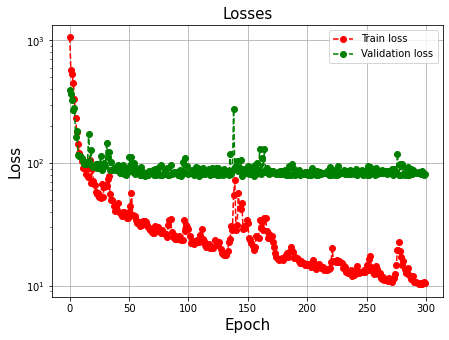

In [23]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

# Testing

In [37]:
# Load network parameters
model.load_state_dict(torch.load(f'Models/first_working_model_params.pth'))

<All keys matched successfully>

In [32]:
### Evaluation on test set
with torch.no_grad():
    for data in test_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, shapes, counts = data
        inputs = inputs.to(device)
        # forward 
        outputs = model(inputs, "Test")


### Statistics on the test set

In [33]:
idx = 2
input_image = inputs.detach().cpu().numpy()[idx]
predicted_map = outputs[idx]
original_map = labels[idx]

print("Predicted map:")
print("Shape",predicted_map.shape)
print("Min", predicted_map.min())
print("Maxp",predicted_map.max())
print("")
print("Original map:")
print("Shape",original_map.shape)
print("Min",original_map.min())
print("Maxp",original_map.max())

Predicted map:
Shape torch.Size([1, 224, 224])
Min tensor(0.4722)
Maxp tensor(14.8427)

Original map:
Shape torch.Size([1, 224, 224])
Min tensor(0.)
Maxp tensor(24.5207)


Basically it is predicting all as 0 and thats why it is achieving such a low loss, so i will enlarge it to get better results.

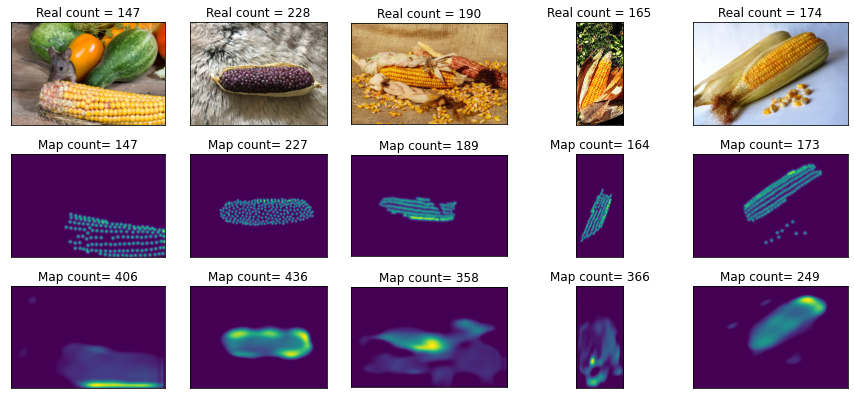

In [34]:
elements = [0,1,2,3,4]#random.sample([i for i in range(len(test_dataset))], 5)

fig, axs = plt.subplots(3, 5, figsize=(12,6))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    ### Move the images to the right shapes
    UP = nn.Upsample(size=(shapes[0][idx],shapes[1][idx]),mode='bilinear')
    img = inputs[idx]#.numpy().transpose(1, 2, 0)
    img = img[None, :]
    img = UP(img)
    img = img[0].numpy().transpose(1, 2, 0)

    label = labels[idx]#.numpy().transpose(1, 2, 0)
    label = label[None, :]
    label = UP(label)
    label = label[0].numpy().transpose(1, 2, 0)
    
    map_ = outputs[idx]#.numpy().transpose(1, 2, 0)
    map_ = map_[None, :]
    map_ = UP(map_)
    map_ = map_[0].numpy().transpose(1, 2, 0) 
    
    # Plot the reconstructed image
    axs[i].imshow(img)
    axs[i].set_title(f"Real count = {count[idx]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(label)
    axs[i+5].set_title(f"Map count= {int(label.sum()/1e4)}")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
    axs[i+10].imshow(map_)
    axs[i+10].set_title(f"Map count= {int(map_.sum()/1e4)}")
    axs[i+10].set_xticks([])
    axs[i+10].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

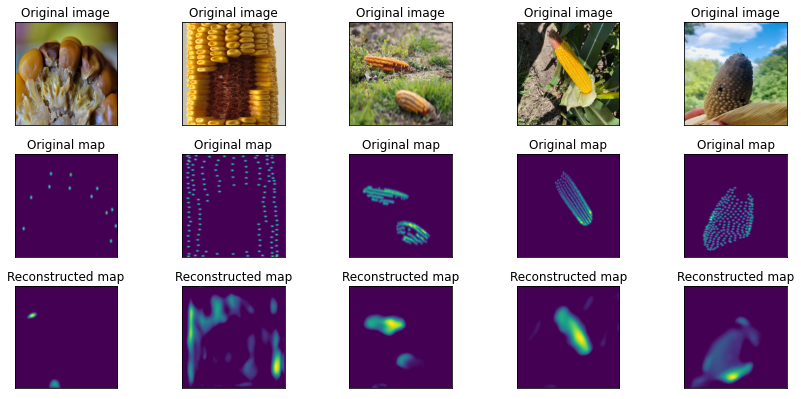

In [27]:
elements = random.sample([i for i in range(len(test_dataset))], 5)

fig, axs = plt.subplots(3, 5, figsize=(12,6))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    predicted_map = outputs[idx][0]
    original_map = labels[idx][0]
    input_image = input_image = inputs.detach().cpu().numpy()[idx]
    # Plot the reconstructed image
    axs[i].imshow(input_image.transpose(1, 2, 0))
    axs[i].set_title("Original image")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(original_map)
    axs[i+5].set_title("Original map")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
    axs[i+10].imshow(predicted_map)
    axs[i+10].set_title('Reconstructed map')
    axs[i+10].set_xticks([])
    axs[i+10].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

In [31]:
mobilenet = torchvision.models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\hilar/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:09<00:00, 1.48MB/s]


In [34]:
print(mobilenet.features)

Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [79]:
#####################################################################
#####################################################################
# keep this to upsample the images and get the right count
# for this to work we need the original image size
# which is not simple to pass but ill need it for the final count only

label = train_labels[0]
print(label.size())
# I need to add a dummy axis simulating the minibatch dimension
label = label[None, :]
print(label.size())

# Upsample to the right dimension
m = nn.Upsample(size=(1280,1920),mode='bilinear')
label_2 = m(label)
print(label_2.size())

torch.Size([1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 1280, 1920])


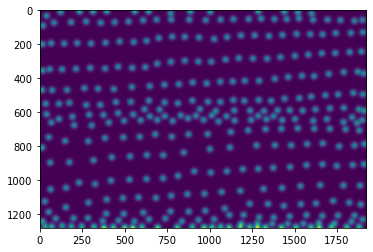

In [80]:
plt.imshow(label_2[0].numpy().transpose(1, 2, 0))

In [81]:
np.sum(label_2[0].numpy())

340.00116

In [28]:
!pip install segmentation-models-pytorch

  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=5d937cb9e2fb7266b8324f5c3439e4fc2a6c284b3dd9f5f62a289cbe8451bc98
  Stored in directory: c:\users\hilar\appdata\local\pip\cache\wheels\84\b9\90\25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=57ee697baa6b54afc43622c6a685f27b1c6a1383c03e28b3f153f9b006ae7735
  Stored in directory: c:\users\hilar\appdata\local\pip\cache\wheels\ed\fa\b9\5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels


In [29]:
import segmentation_models_pytorch as smp


In [30]:
model = smp.Unet('resnet34', encoder_weights='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\hilar/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:36<00:00, 2.39MB/s]


In [31]:
model.encoder

ResNetEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T